# 第3章　最尤推定法：確率を用いた推定理論

## 3.1 確率モデルの利用

**[03ML-01]**

必要なモジュールをインポートします。

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

from numpy.random import normal

**[03ML-02]**

正弦関数 $y=\sin(2\pi x)$ に、平均 0、標準偏差 0.3 の正規分布のノイズを載せたデータセットを生成する関数を定義します。

これは、$0\le x\le 1$ の区間を等分した `num` 個の点 $\{x_n\}_{n=1}^N$ に対して、対応する $\{t_n\}_{n=1}^N$ の値を生成します。

In [34]:
def create_dataset(num):
  xs = np.linspace(0, 1, num)
  ts = np.sin(2*np.pi*xs) + normal(loc=0, scale=0.3, size=num)
  return xs, ts

**[03ML-03]**

例として、10 個のデータをトレーニングセットとして生成します。

In [35]:
N = 10 # データ数
xs, ts = create_dataset(N)

DataFrame({'x': xs, 't': ts})

,x,t
0,0.000000,-0.252358
1,0.111111,0.357439
2,0.222222,1.291491
3,0.333333,0.495475
4,0.444444,0.304439
5,0.555556,0.281349
6,0.666667,-0.696008
7,0.777778,-0.775290
8,0.888889,-0.941495
9,1.000000,-0.230829


**[03ML-04]**

グラフ上にプロットすると次のようになります。

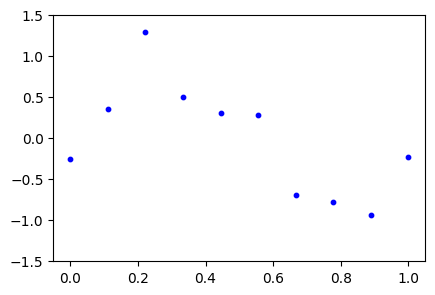

In [36]:
fig = plt.figure(figsize=(6*0.8, 4*0.8))
subplot = fig.add_subplot(1, 1, 1)
subplot.tick_params(axis='x', labelsize=10)
subplot.tick_params(axis='y', labelsize=10)
subplot.set_xlim(-0.05, 1.05)
subplot.set_ylim(-1.5, 1.5)
_ = subplot.scatter(xs, ts, marker='o', s=10, color='blue')

**[03ML-05]**

このデータに対して、最尤推定法でフィッティングした $M$ 次多項式と標準偏差 $\sigma$ の推定値を求める関数を定義します。

引数 `xs`、`ts`にトレーニングセットのデータ、`m` に多項式の次数 $M$ を代入すると、多項式に対応する関数 $f(x)$ のオブジェクトと $\sigma$ の推定値が返ります。

多項式の係数を求める際は、最小二乗法と同じ、次の関係式を利用しています。

$$
\mathbf w = \left(\boldsymbol\Phi^{\rm T}\boldsymbol\Phi\right)^{-1}\boldsymbol\Phi^{\rm T}\mathbf t
$$

標準偏差の推定値は、平方根平均二乗誤差として計算しています。

$$
\sigma = E_{\rm{RMS}}=\sqrt{\frac{2E_D}{N}} = \sqrt{\frac{1}{N}\sum_{n=1}^N\left\{f(x_n)-t_n\right\}^2}
$$


In [37]:
def resolve(xs, ts, m):
  phi = np.array([[x**k for k in range(m+1)] for x in xs])
  tmp = np.linalg.inv(np.dot(phi.T, phi))
  ws = np.dot(np.dot(tmp, phi.T), ts)

  def f(x):
    y = 0
    for i, w in enumerate(ws):
      y += w * x**i 
    return y

  sigma = np.sqrt(np.sum((f(xs) - ts)**2) / len(xs))

  return f, sigma

**[03ML-06]**

これらを用いて、結果をグラフに可視化する関数を定義します。

In [38]:
def show_result(subplot, xs, ts, m):
  f, sigma = resolve(xs, ts, m)
  subplot.tick_params(axis='x', labelsize=10)
  subplot.tick_params(axis='y', labelsize=10)
  subplot.set_xlim(-0.05, 1.05)
  subplot.set_ylim(-1.5, 1.5)
  subplot.set_title('M={}'.format(m), fontsize=10)

  # トレーニングセットを表示
  subplot.scatter(xs, ts, marker='o', s=10, color='blue', label=None)

  # 真の曲線を表示
  linex = np.linspace(0, 1, 100)
  liney = np.sin(2*np.pi*linex)
  subplot.plot(linex, liney, color='green', linestyle='--')

  # 多項式近似の曲線を表示
  linex = np.linspace(0, 1, 100)
  liney = f(linex)
  label = 'sigma={:.2f}'.format(sigma)
  subplot.plot(linex, liney, color='red', label=label)
  subplot.plot(linex, liney+sigma, color='red', linestyle='--')
  subplot.plot(linex, liney-sigma, color='red', linestyle='--')
  subplot.legend(loc=1, fontsize=10)

**[03ML-07]**

先ほど生成したトレーニングセットを用いて、0, 1, 3, 9次多項式でフィッティングした結果を表示します。

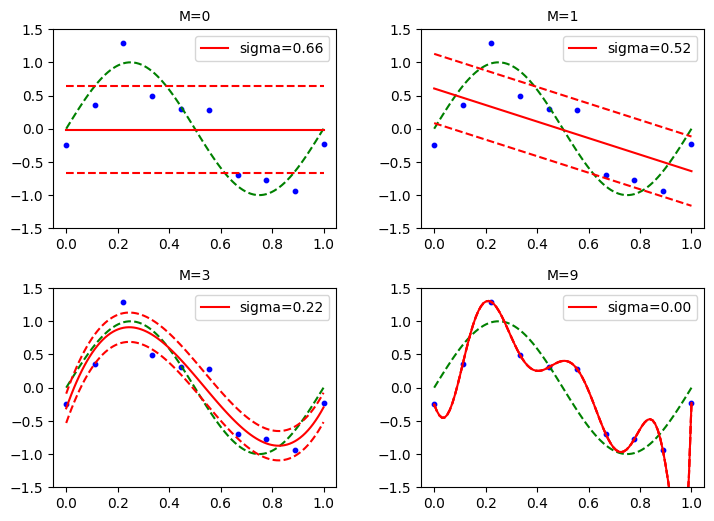

In [39]:
fig = plt.figure(figsize=(12*0.7, 8.5*0.7))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, m in enumerate([0, 1, 3, 9]):
  subplot = fig.add_subplot(2, 2, i+1)
  show_result(subplot, xs, ts, m)

**[03ML-08]**

トレーニングセットから推定された多項式 $f(x)$ と標準偏差 $\sigma$ を用いて、与えられたデータセット $\{(x_n, t_n)\}_{n=1}^N$ の対数尤度 $\log P$ を計算する関数を定義します。

$$
\log P = \frac{N}{2}\log\beta - \frac{N}{2}\log 2\pi - \beta E_D\ \ 
\left(\beta = \frac{1}{\sigma^2},\ E_D = \frac{1}{2}\sum_{n=1}^N\{f(x_n)-t_n\}^2\right)
$$

In [40]:
def log_likelihood(xs, ts, f, sigma):
  n = len(xs)
  beta = 1 / sigma**2
  err = 0.5 * np.sum((f(xs) - ts)**2)
  log_p = 0.5 * n * np.log(beta) - 0.5 * n * np.log(2*np.pi) - beta * err
  return log_p

**[03ML-09]**

多項式の次数を 0〜7 に変化させながら、対数尤度 $\log P$ のグラフを描く関数を用意します。

In [41]:
def show_loglikelihood_trend(xs, ts, val_xs, val_ts):
  log_ps = {'Training set': [], 'Test set': []}
  for m in range(0, 8):
    f, sigma = resolve(xs, ts, m)
    log_ps['Training set'].append(log_likelihood(xs, ts, f, sigma))
    log_ps['Test set'].append(log_likelihood(val_xs, val_ts, f, sigma))

  df = DataFrame(log_ps)
  ax = df.plot(figsize=(8*0.7, 5*0.7), style=['-', '--'], grid=True,
               xticks=range(0, 8), fontsize=10)
  ax.set_title(label='Log likelihood', fontdict={'fontsize':10})
  ax.legend(loc=0, fontsize=10)

**[03ML-10]**

トレーニングセットとは独立に生成したテストセットを用意します。

In [42]:
val_xs, val_ts = create_dataset(N)

DataFrame({'val_x': val_xs, 'val_t': val_ts})

,val_x,val_t
0,0.000000,-0.002468
1,0.111111,0.576218
2,0.222222,1.241448
3,0.333333,1.279287
4,0.444444,0.704401
5,0.555556,-0.355214
6,0.666667,-1.047491
7,0.777778,-0.645154
8,0.888889,-0.547875
9,1.000000,-0.159087


**[03ML-11]**

トレーニングセットとテストセットに対する対数尤度を計算して、結果をグラフ表示にします。

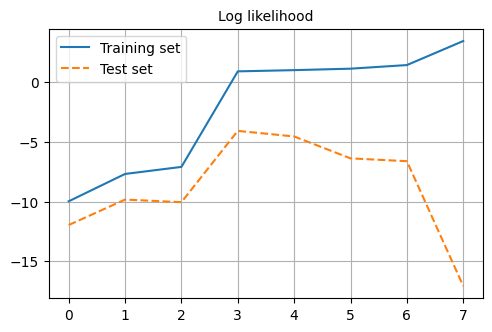

In [43]:
show_loglikelihood_trend(xs, ts, val_xs, val_ts)

**[03ML-12]**

同じ計算をデータ数を増やして実施してみます。

N = 100 でトレーニングセットとテストセットを用意します。

In [44]:
N=100
xs, ts = create_dataset(N)
val_xs, val_ts = create_dataset(N)

**[03ML-13]**

最尤推定法でフィッテインングした結果を表示します。

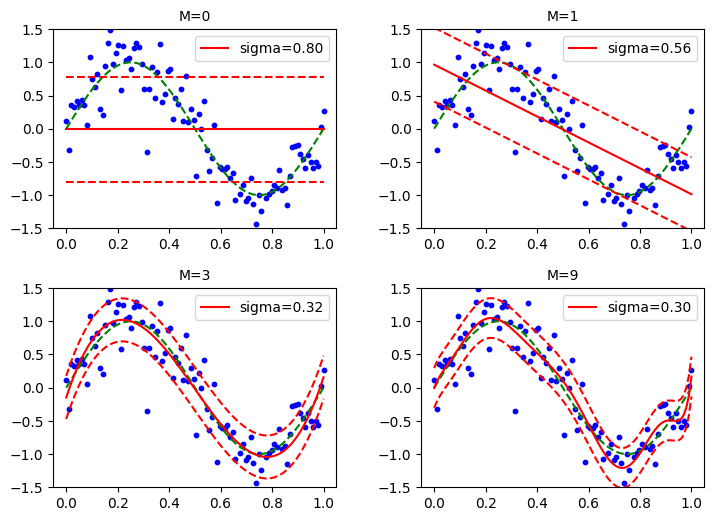

In [45]:
fig = plt.figure(figsize=(12*0.7, 8.5*0.7))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for i, m in enumerate([0, 1, 3, 9]):
  subplot = fig.add_subplot(2, 2, i+1)
  show_result(subplot, xs, ts, m)

**[03ML-14]**

トレーニングセットとテストセットに対する対数尤度の変化を表示します。

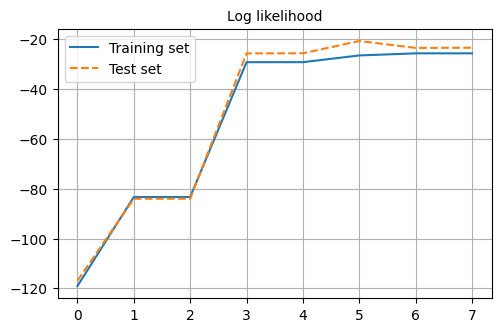

In [46]:
show_loglikelihood_trend(xs, ts, val_xs, val_ts)